In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2016-08-23 00:00:00


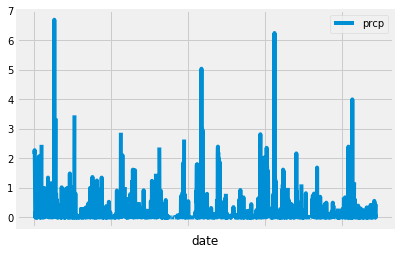

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last=session.query(func.max(Measurement.date)).first()
first =query_date = dt.datetime.strptime(last[0], '%Y-%m-%d') - dt.timedelta(days=365)

# Calculate the date 1 year ago from the last data point in the database
print(first)
# Perform a query to retrieve the data and precipitation scores
results=(session
         .query(Measurement.date, 
                Measurement.prcp)
         .filter(Measurement.date > first)
         .statement)

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.read_sql(results, engine).set_index('date').sort_values('date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(kind="line")
plt.xlabel("date")
plt.legend(loc="best")
plt.show()

![precipitation](Images/precipitation.png)

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [21]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement).group_by(Measurement.station).count()
print(stations)

9


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
(session.query(Measurement.station,func.count(Measurement.station)) 
 .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all())

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
stat=session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

calculations=(session
              .query(*sel)
              .filter(Measurement.station==stat)
              .all())

print(calculations)

[(54.0, 85.0, 71.66378066378067)]


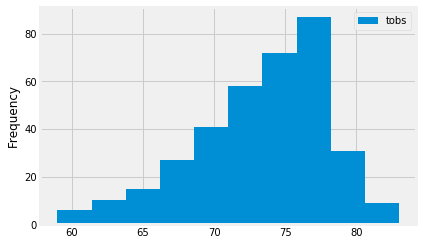

In [46]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_htemp=session.query(func.max(Measurement.date)).filter(Measurement.station=='USC00519281').first()[0]
first_htemp = dt.datetime.strptime(last_htemp, '%Y-%m-%d') - dt.timedelta(days=365)
results=(session.query(Measurement.date, Measurement.tobs)
         .filter(Measurement.date >= first_htemp, 
                 Measurement.station=='USC00519281')
         .statement)
df_temp = pd.read_sql(results, engine).set_index('date').sort_values('date',ascending=False)

df_temp.plot(kind='hist')

![precipitation](Images/station-histogram.png)

In [47]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [53]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = (calc_temps('2011-02-28', '2011-03-05'))
print(trip)

#i'm a little confused with the wording for "your trip". what trip??

[(61.0, 69.75510204081633, 75.0)]


Text(0.5,1,'Trip Avg Temp')

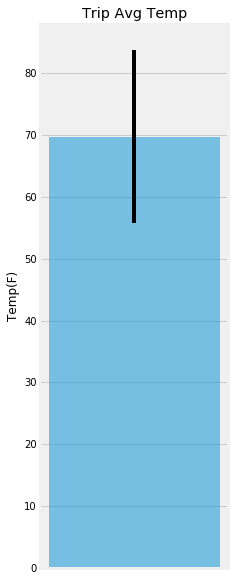

In [68]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error= trip[0][2]- trip[0][0]
average = [trip[0][1]]
xvals = range(len(average))

fig,ax = plt.subplots(figsize=(3,10))
ax.bar(xvals, average, yerr=error,alpha=0.5)
ax.set_xticks([])
plt.ylabel("Temp(F)")
plt.title("Trip Avg Temp")

In [69]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date="01-01"
vacation_range=7
end_date=(dt.datetime.strptime(start_date, '%m-%d') + dt.timedelta(days=vacation_range)).strftime('%m-%d')

sel=[Measurement.station,
     Station.name,
     func.sum(Measurement.prcp).label("sumPrcp"),
     Station.latitude,
     Station.longitude,
     Station.elevation
]
result=(session.query(*sel)
        .group_by(Measurement.station)
        .filter(Measurement.station==Station.station)
        .filter(func.strftime("%m-%d", Measurement.date) >= start_date, func.strftime("%m-%d", Measurement.date) <= end_date)
        .order_by(func.sum(Measurement.prcp).desc())
        .all())


print(result)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 23.359999999999996, 21.3331, -157.8025, 152.4), ('USC00519281', 'WAIHEE 837.5, HI US', 8.079999999999997, 21.45167, -157.84888999999998, 32.9), ('USC00513117', 'KANEOHE 838.1, HI US', 6.739999999999998, 21.4234, -157.8015, 14.6), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 5.909999999999998, 21.33556, -157.71139, 19.5), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2.8599999999999994, 21.5213, -157.8374, 7.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 2.5700000000000003, 21.2716, -157.8168, 3.0), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 2.44, 21.3152, -157.9992, 0.9), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 0.68, 21.4992, -158.0111, 306.6), ('USC00517948', 'PEARL CITY, HI US', 0.65, 21.3934, -157.9751, 11.9)]


## Optional Challenge Assignment

In [70]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [77]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates
trip=["01-01","01-02","01-03","01-04","01-05","01-06","01-07"]
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
normals=map(daily_normals,trip)
z=dict(zip([f"2018-{d}" for d in trip],[x[0] for x in normals]))
z

{'2018-01-01': (62.0, 69.15384615384616, 77.0),
 '2018-01-02': (60.0, 69.39622641509433, 77.0),
 '2018-01-03': (62.0, 68.9090909090909, 77.0),
 '2018-01-04': (58.0, 70.0, 76.0),
 '2018-01-05': (56.0, 67.96428571428571, 76.0),
 '2018-01-06': (61.0, 68.96491228070175, 76.0),
 '2018-01-07': (57.0, 68.54385964912281, 76.0)}

In [72]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_trip = pd.DataFrame.from_dict(z, orient='index',
                     columns=['tmin', 'tavg', 'tmax'])
df_trip

,tmin,tavg,tmax
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


Text(0.5,0,'Date')

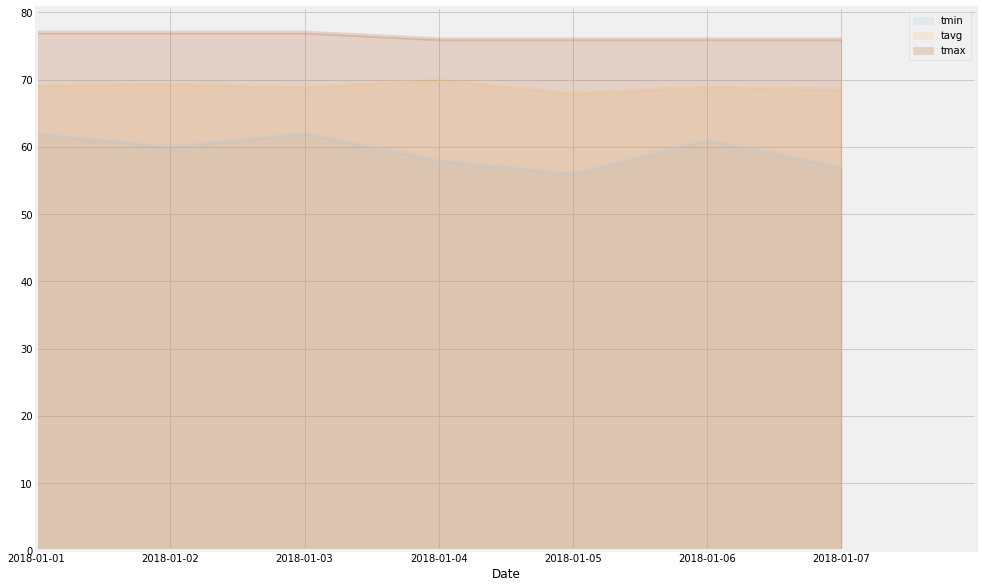

In [86]:
# Plot the daily normals as an area plot with `stacked=False`
from matplotlib import cm
ax=df_trip.plot(kind='area', stacked=False,figsize=(15,10), alpha=0.2,title='',cmap = cm.get_cmap('Paired'))
ax.set_xticklabels(df_trip.index)
plt.xlim(0,7)
plt.xlabel("Date")